# Thingi10k EDA

In the thingi10k_metadata_retrieval notebook, we built an Thingi10k index. This index contains multiple points of metadata about each stl object as well as the filename of the stl object itself.

In this notebook, our goal is to learn more about the dataset. Specifically, we have these questions:

1. How big/small are the stl objects?
2. Will we need to normalize the coordinates?
3. What are the available tags?


In [19]:
import pandas as pd
# ask matplotlib to show figures in notebook
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [6]:
import env
from data import THINGI10K_INDEX
df = pd.read_csv(THINGI10K_INDEX)

## Num Vertices

In [17]:
# https://stackoverflow.com/questions/40347689/dataframe-describe-suppress-scientific-notation
df.num_vertices.describe().apply(lambda x: format(x, 'f'))

count       9949.000000
mean       20688.300834
std        71306.385427
min            4.000000
25%          534.000000
50%         2164.000000
75%        10610.000000
max      1577057.000000
Name: num_vertices, dtype: object

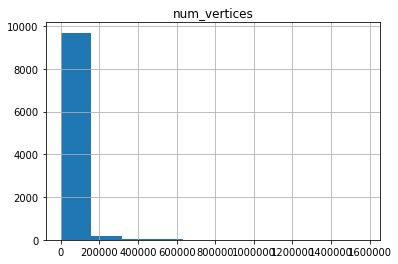

In [21]:
_ = df.hist(column='num_vertices')

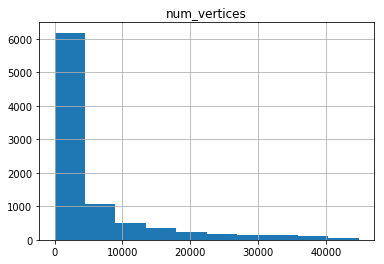

In [29]:
# what if we only look at the top 90%?

# https://stackoverflow.com/questions/18580461/eliminating-all-data-over-a-given-percentile
_ = df[df.num_vertices < df.num_vertices.quantile(.90)].hist(column='num_vertices')

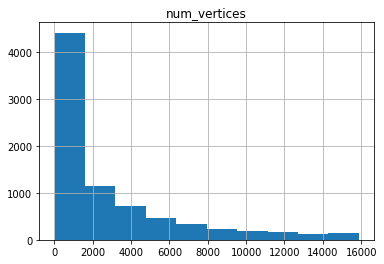

In [30]:
# what if we only look at the top 80%?

# https://stackoverflow.com/questions/18580461/eliminating-all-data-over-a-given-percentile
_ = df[df.num_vertices < df.num_vertices.quantile(.80)].hist(column='num_vertices')

### Takeaways

* Count < 1000: the Thingi10k dataset comes with a handful of .ply and .obj files; we ignore those.
* Histogram with long right-tail: it might be a good idea to ignore the largest files as they are not as representative and to keep input data low for the network
    * 80% looks like a good option; it cuts out 10% of the data points compared to 90% but cuts the max vertex count in half

## Size of STL Input

We will be inputting the stl vertices into the network and want to know how much memory we will potentially be using to calculate a good batch size.

In [15]:
# if a float is 4 bytes and each vertex is 3 floats (x,y,z coordinates)
# note that the actual stl file has extra info like normal vectors, name, etc.
# our network won't care about that info, so we are focused on only vertices here.
df['stl_data_points'] = df.num_vertices * 3
df.stl_data_points.describe().apply(lambda x: format(x, 'f'))

count       9949.000000
mean       62064.902503
std       213919.156282
min           12.000000
25%         1602.000000
50%         6492.000000
75%        31830.000000
max      4731171.000000
Name: stl_data_points, dtype: object

In [16]:
df['stl_size_bytes'] = df.stl_data_points * 4
df.stl_size_bytes.describe().apply(lambda x: format(x, 'f'))

count        9949.000000
mean       248259.610011
std        855676.625126
min            48.000000
25%          6408.000000
50%         25968.000000
75%        127320.000000
max      18924684.000000
Name: stl_size_bytes, dtype: object

In [13]:
# gb
df['stl_size_gb'] = df.stl_size_bytes / 1024 / 1024 / 1024
df.stl_size_gb.describe().apply(lambda x: format(x, 'f'))

count    9949.000000
mean        0.000231
std         0.000797
min         0.000000
25%         0.000006
50%         0.000024
75%         0.000119
max         0.017625
Name: stl_size_gb, dtype: object

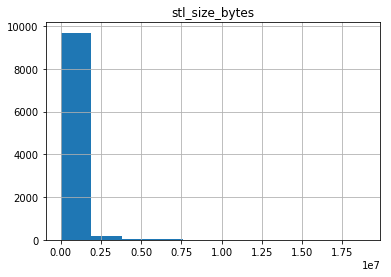

In [31]:
_ = df.hist(column='stl_size_bytes')

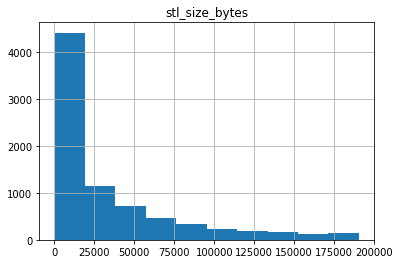

In [32]:
_ = df[df.num_vertices < df.num_vertices.quantile(.80)].hist(column='stl_size_bytes')

### Takeaways

* As expected, the memory usage of the input is linearly related to the number of vertices (the histograms have the same shape)

### Batch Size Memory Usage

Let's set an arbritary goal of 1GB for memory usage for our batches. What should the batch size be to reach that goal?

In [37]:
ARBRITARY_MEM_GOAL = 1
avg_gb = df.stl_size_gb.mean()
batch_size = ARBRITARY_MEM_GOAL / avg_gb
batch_size

4325.076575896419

With a 1GB goal, our batch size can be fairly large. Even without counting for padding, it is safe to assume that a batch size of < 1000 will be safe. 

## STL Coordinates

Are coordinates all positive?

From [Wikipedia](https://en.wikipedia.org/wiki/STL_(file_format)), "In the original specification, all STL coordinates were required to be positive numbers, but this restriction is no longer enforced and negative coordinates are commonly encountered in STL files today."

This means that we will likely need to normalize our coordinates. What's the best way to do so?

In [39]:
import env
from data.thingi10k import thingi10k_batch_generator, thingi10k_df, thingi10k_max_length
from data import THINGI10K_INDEX_100
df = thingi10k_df(THINGI10K_INDEX_100, pctile=.80)
n_samples = len(df)

In [43]:
for batch in thingi10k_batch_generator(df, 10, flat=True):
    print('****')
    print(len(batch))
    print(len(batch[0]))
    print(batch[0].max())
    print(batch[0].min())

****
10
2430
142.8358
-27.47818
****
10
4752
1.21691
-4.1723297e-07
****
10
39204
42.541275
-29.113377
****
10
95760
50.390003
0.0
****
10
86616
29.5
-29.5
****
10
161460
5.829913
-5.152635
****
10
66834
59.49368
-32.09416
****
9
17856
55.45684
-23.35605


## Thingi10k Tags

In [7]:
import env
from data.thingi10k import Thingi10k
import pandas as pd

thingi = Thingi10k.init10k()

In [8]:
thingi.df.tags

0                          ['rover', 'spider', 'walking']
1       ['articulado', 'ball_jointed', 'cool', 'doll',...
2       ['christmas', 'gift', 'holiday', 'makerbot', '...
3       ['laser', 'laser_chess', '3D', 'board_game', '...
4       ['flute', 'music', 'recorder', 'empire_state_b...
5                                                     NaN
6        ['clock', 'desk_clock', 'divers_watch', 'watch']
7       ['bird', 'birdhouse', 'BirdhouseChallenge', 'B...
8                                         ['interesting']
9       ['optimus_prime', 'tardis', 'toy', 'transformer']
10      ['architecture', 'budmen', 'cloud', 'cloud_fac...
11                                ['animal', 'sculpture']
12      ['board', 'chess', 'dragon', 'fantasy', 'fire'...
13      ['Action_Figure', 'anime', 'ModioChallenge', '...
14                        ['hex', 'screw', 'star', 'toy']
15      ['4-8-8-4', 'Locomotive', 'railroad', 'scale_m...
16                 ['balloon', 'whistle_goes_wooo_WOOOO']
17            

In [11]:
pd.DataFrame(thingi.df.tags.values.tolist())

,0
0,"['rover', 'spider', 'walking']"
1,"['articulado', 'ball_jointed', 'cool', 'doll',..."
2,"['christmas', 'gift', 'holiday', 'makerbot', '..."
3,"['laser', 'laser_chess', '3D', 'board_game', '..."
4,"['flute', 'music', 'recorder', 'empire_state_b..."
5,NaN
6,"['clock', 'desk_clock', 'divers_watch', 'watch']"
7,"['bird', 'birdhouse', 'BirdhouseChallenge', 'B..."
8,['interesting']
9,"['optimus_prime', 'tardis', 'toy', 'transformer']"


In [15]:
import pandas as pd

df = pd.DataFrame(data=[[['8','10','12'], 'A'],
                        [['7','9','11', 14], 'B']])

print(df[0])

df[0].apply(pd.Series)

0       [8, 10, 12]
1    [7, 9, 11, 14]
Name: 0, dtype: object


,0,1,2,3
0,8,10,12,NaN
1,7,9,11,14.0


In [19]:
# https://stackoverflow.com/questions/46391430/working-with-lists-in-pandas-applypd-series-doesnt-work-an-alternative-sol
df = thingi.df.tags.str.strip('[]').str.replace("'", "").str.split(', ', expand=True)
print (df)

                   0                        1                   2   \
0               rover                   spider             walking   
1          articulado             ball_jointed                cool   
2           christmas                     gift             holiday   
3               laser              laser_chess                  3D   
4               flute                    music            recorder   
5                 NaN                      NaN                 NaN   
6               clock               desk_clock        divers_watch   
7                bird                birdhouse  BirdhouseChallenge   
8         interesting                     None                None   
9       optimus_prime                   tardis                 toy   
10       architecture                   budmen               cloud   
11             animal                sculpture                None   
12              board                    chess              dragon   
13      Action_Figur